# Tom and Jerry Classification model

In [1]:
#pip install opencv-python

In [2]:
#pip install keras

In [3]:
#pip install tensorflow

In [4]:
# import necessary library
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    
%matplotlib inline
import pandas as pd
import numpy as np    
from keras.preprocessing import image   # for preprocessing the images
from keras.utils import to_categorical # one hot encoding
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, Dropout, Flatten
import os  #  Allows Python programs to interact with OS such as uch as manipulating files, running system commands.
from skimage.transform import resize   # for resizing images
from skimage.io import imread  # Import imread explicitly
from skimage import io  # Correct import statement for skimage.io
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, classification_report
from sklearn.metrics import auc, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical



C:\Users\admin\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
#Load the data (mapping)
df = pd.read_csv("mapping.csv") 
df.head(5)

filename  tom  jerry
0  frame0.jpg    0      0
1  frame1.jpg    0      0
2  frame2.jpg    0      0
3  frame3.jpg    0      0
4  frame4.jpg    0      0

# Data Preprocessing

In [6]:
# Rename columns
df.rename(columns={'filename': 'image_id', 'tom': 'label'}, inplace=True)

# transforming method of labels
def transform_label(row):
    if row['label'] == 1 and row['jerry'] == 1:
        return 3  # Both Tom and Jerry
    elif row['label'] == 1:
        return 1  # Only Tom
    elif row['jerry'] == 1:
        return 2  # Only Jerry
    else:
        return 4  # Neither Tom nor Jerry

#apply method    
df['label'] = df.apply(transform_label, axis=1)

# Drop 'jerry' column since it's no longer needed
df.drop(columns=['jerry'], inplace=True)

df.head(25)

image_id  label
0    frame0.jpg      4
1    frame1.jpg      4
2    frame2.jpg      4
3    frame3.jpg      4
4    frame4.jpg      4
5    frame5.jpg      4
6    frame6.jpg      4
7    frame7.jpg      4
8    frame8.jpg      4
9    frame9.jpg      4
10  frame10.jpg      4
11  frame11.jpg      4
12  frame12.jpg      2
13  frame13.jpg      4
14  frame14.jpg      1
15  frame15.jpg      1
16  frame16.jpg      4
17  frame17.jpg      2
18  frame18.jpg      3
19  frame19.jpg      2
20  frame20.jpg      4
21  frame21.jpg      4
22  frame22.jpg      4
23  frame23.jpg      4
24  frame24.jpg      4

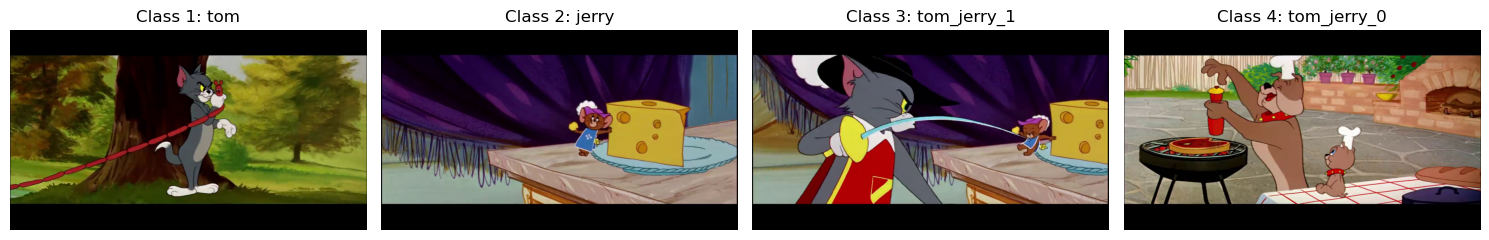

Columns: ['image_id', 'label', 'class_name']

Head(5):
      image_id  label   class_name
0  frame0.jpg      4  tom_jerry_0
1  frame1.jpg      4  tom_jerry_0
2  frame2.jpg      4  tom_jerry_0
3  frame3.jpg      4  tom_jerry_0
4  frame4.jpg      4  tom_jerry_0


In [7]:
# Show sample image for each class
# Define class 
class_map = {
    1: 'tom',
    2: 'jerry',
    3: 'tom_jerry_1',  # Tom and Jerry
    4: 'tom_jerry_0'   # No Tom nor Jerry
}

# Example usage
dataset_path = r'C:\Users\admin\Desktop\Tom&Jerry\dataset'

# Mapping
def display_sample_images(dataset_path, class_map):
    fig, axs = plt.subplots(1, len(class_map), figsize=(15, 5))

    for class_label, class_name in class_map.items():
        # Find the corresponding class index in the subplot array
        plot_index = class_label - 1  # Subtract 1 to convert to zero-indexed
        
        # vlookup
        sample_image = None
        class_dir = os.path.join(dataset_path, class_name)
        # sample images
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg'):
                sample_image = imread(os.path.join(class_dir, filename))
                break
        
        # Display 
        axs[plot_index].imshow(sample_image)
        axs[plot_index].set_title(f'Class {class_label}: {class_name}')
        axs[plot_index].axis('off')

    plt.tight_layout()
    plt.show()

# Create class name column
df['class_name'] = df['label'].map(class_map)

# Display sample images for each class
display_sample_images(dataset_path, class_map)

# Display column names and first 5 rows of the DataFrame
print("Columns:", df.columns.tolist())
print("\nHead(5):\n", df.head())

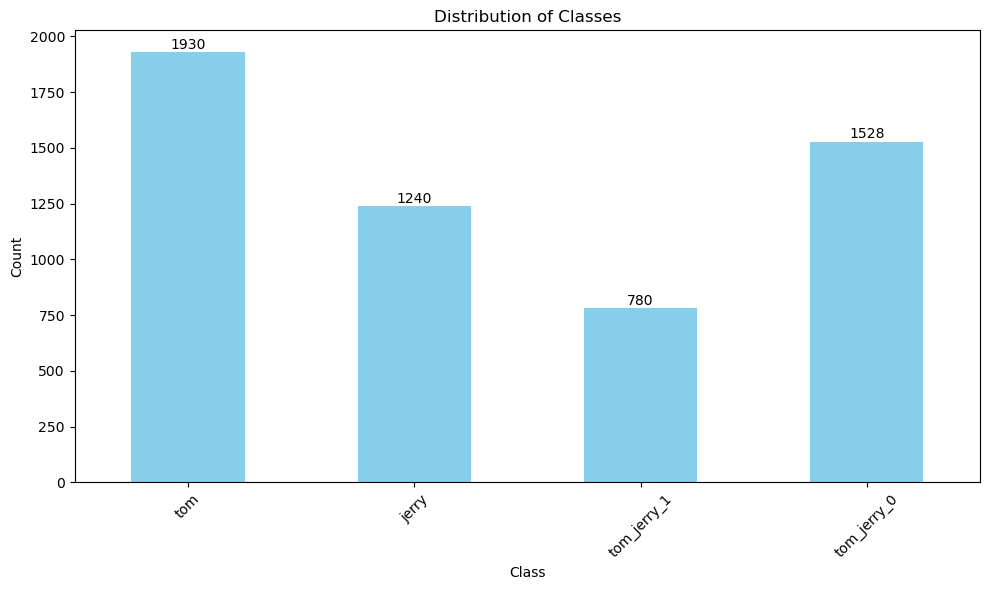

In [8]:
# Data exploration
# Count the number of occurrences of each class and order them
class_counts = df['class_name'].value_counts()[['tom', 'jerry', 'tom_jerry_1', 'tom_jerry_0']]

# Plotting the bar chart with annotations
plt.figure(figsize=(10, 6))
bars = class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate each bar with the count of images
for i, count in enumerate(class_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

In [9]:
# Mapping labels at CSV to image folders and keep in array 
dataset_path = r'C:\Users\admin\Desktop\Tom&Jerry\dataset'

# Define class labels based on folder names (maping folder with labels)
class_map = {
    'tom': 1,
    'jerry': 2,
    'tom_jerry_0': 4,
    'tom_jerry_1': 3
}

# Initialize lists to store images and labels
X = []
y = []

# Iterate through each class folder (mapping and resize image)
for class_name, label in class_map.items():
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = imread(img_path)  
        img_resized = resize(img, output_shape=(224, 224, 3), preserve_range=True).astype(np.float32)
        X.append(img_resized)
        y.append(label)

# Convert lists to arrays (converts an integers to binary class matrix(vector)
X = np.array(X)
y = np.array(y)

In [10]:
# Preprocessing
X_p = preprocess_input(X)

# Print shapes of X_p and y
print("Shape of X_p:", X_p.shape)
print("Shape of y:", y.shape)
# number of images: 5478, 224: size of images, 3: RBG colors

Shape of X_p: (5478, 224, 224, 3)
Shape of y: (5478,)


# Apply Model

In [11]:
# Split data into training (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_p, y, test_size=0.20, random_state=42)

# Split the remaining data into validation and training 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.10, random_state=42)
# trainset = 72%, validation = 8%, test = 20%
# Print shapes of each set
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3943, 224, 224, 3)
Shape of y_train: (3943,)
Shape of X_val: (439, 224, 224, 3)
Shape of y_val: (439,)
Shape of X_test: (1096, 224, 224, 3)
Shape of y_test: (1096,)


In [12]:
# Load VGG16 model without the fully connected layers or top layer (include_top=False). 
# The reason to exclude the fully connected because thee need of feature extraction that give a flexibility to customize specific image.
# VGG16 is CNN architecture that was proposed by Karen Simonyan, consisting of 16 weight layers.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features from training set (apply the pre-trained VGG16 model to these images to extract features)
X_train_features = base_model.predict(X_train)
X_val_features = base_model.predict(X_val)

# Check shapes of extracted features
print("Shape of X_train_features:", X_train_features.shape)
print("Shape of X_val_features:", X_val_features.shape)
# number of images: 4190, size of feature map(breaking image into multiple images as output size): 7 X 7, Filters: 512.
# Feature Maps: CNN breaks image down into multiple feature maps. Each feature map shows different features are found in the image such as edge of image, central image. 
# The number of filters(512) indicates how the model can recognize and highlight in each part of the image.

124/124 ━━━━━━━━━━━━━━━━━━━━ 624s 5s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step
Shape of X_train_features: (3943, 7, 7, 512)
Shape of X_val_features: (439, 7, 7, 512)


In [13]:
# Reshape features to be compatible with fully connected layer
# After convolution and pooling, we need to reshape into a format that is compatible with a fully connected layer 
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_val_features = X_val_features.reshape(X_val_features.shape[0], -1)

# Check shapes after reshaping
print("Shape of X_train_features after reshape:", X_train_features.shape)
print("Shape of X_val_features after reshape:", X_val_features.shape)
# 25088 is the result of flattening (7*7*512)

Shape of X_train_features after reshape: (3943, 25088)
Shape of X_val_features after reshape: (439, 25088)


In [14]:
# Normalize data
X_train_features = X_train_features / X_train_features.max()
X_val_features = X_val_features / X_train_features.max()

In [15]:
# 1.Building model
# Initialize a Sequential model (sequentially feed input to process)
model = Sequential()

# Fully connection adjust image for better visualization of AI by using relu
# Add layers for fully connection
# 1. Dense: Adds a fully connected layer (convert vector into single value to feed the classification model)
# relu function will learn complex pattern to make a better prediction. (adjust image for AI by removing background or not imaportant image)
# softmax typically predicted the class with highest probability output. This help allow to easily determine.
# 2. Dropout: to generallize the model by reducing the number of feature extraction by randomly sets 50% of the activations to zero during training to prevent the overfitting. 
model.add(Dense(512, activation='relu', input_dim=X_train_features.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  

# Print model summary (A detailed overview of CNN architecture: reduce the complexity two times)
# Every time to pooling or dropout. the size of images will significantly reduce
model.summary()
# Param is the number of training. for example, (25088 is input before fully connected + 1 is an error) * 512 is filter = 12,845,568

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,978,181 (49.51 MB)

 Trainable params: 12,978,181 (49.51 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 2.Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert integer labels to categorical format
y_train_cat = to_categorical(y_train - 1, num_classes=5)  # Subtract 1 to make labels zero-indexed
y_val_cat = to_categorical(y_val - 1, num_classes=5)  # Subtract 1 to make labels zero-indexed

# Check shapes after conversion
print("Shape of y_train_cat:", y_train_cat.shape)
print("Shape of y_val_cat:", y_val_cat.shape)

Shape of y_train_cat: (3943, 5)
Shape of y_val_cat: (439, 5)


In [17]:
# 3.Train the model
# Repeat weight adjustment to reduce an error of hidden layer in ANN until get the highest accuracy that is Epoch9 (similar to recalculate in K-means)
# epochs are the way to randomly select one value for weight to calculate output. then repeat it 10 times (in this case)
# batch is a size volumne that feed to train model
# Train the model
history = model.fit(X_train_features, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val_features, y_val_cat))


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.4755 - loss: 1.1773 - val_accuracy: 0.8018 - val_loss: 89.9730
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.8626 - loss: 0.3827 - val_accuracy: 0.8451 - val_loss: 94.5782
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.9123 - loss: 0.2335 - val_accuracy: 0.8405 - val_loss: 127.3064
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.9540 - loss: 0.1454 - val_accuracy: 0.8861 - val_loss: 88.0278
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.9655 - loss: 0.1196 - val_accuracy: 0.8702 - val_loss: 118.4209
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.9668 - loss: 0.1153 - val_accuracy: 0.8724 - val_loss: 107.0751
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.9760 - loss: 0.0871 - val_accuracy: 0.8815 - val_loss: 127.3196
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.9746 - loss

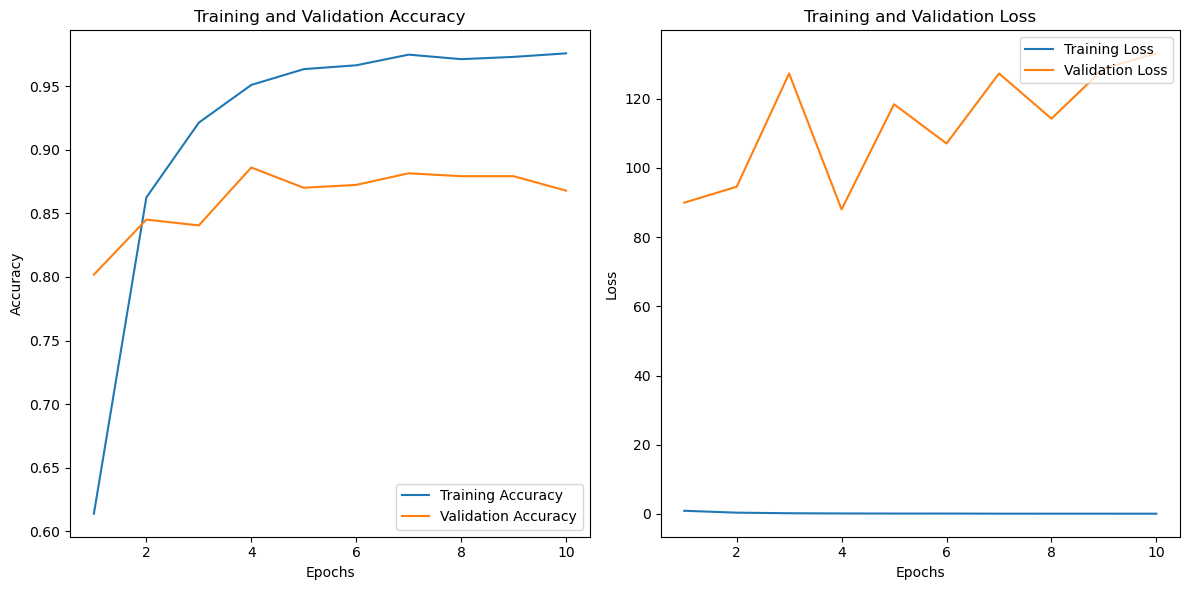

In [18]:
# Extract accuracy and loss from history to visualize the accuracy and loss for training model and validation dataset
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

#Save model
model.save(r"C:\Users\admin\Desktop\Tom&Jerry\tom&jerry_model.h5")


In [19]:
#Preprocessing for testset
# Extract features from training set
X_test_features = base_model.predict(X_test) 

# Reshape features to be compatible with fully connected layer
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

# Normalize data
X_test_features = X_test_features / X_test_features.max()  # Using max value of X_test_features for normalization

# Make predictions
y_pred_prob = model.predict(X_test_features)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Convert y_test to categorical format 
y_test_cat = to_categorical(y_test - 1, num_classes=5)  # 5 classes, subtract 1 for zero-indexed labels

# Convert y_test_cat back to integer for compatible format 
y_test_int = np.argmax(y_test_cat, axis=1)

# Compute overall accuracy
accuracy = accuracy_score(y_test_int, y_pred)

print(f'Overall Accuracy: {accuracy:.2f}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Overall Accuracy: 0.87


In [35]:
# Print a sample of y_pred
sample_size = 20  # Number of samples to print

print("Sample of y_pred:")
print(y_pred[:sample_size])
print("Sample of y_test:")
print(y_test[:sample_size])
print("Sample of y_test_cat:")
print(y_test_cat[:sample_size])  # one hot encoding
print("Sample of y_test_int:")
print(y_test_int[:sample_size])

Sample of y_pred:
[1 2 0 3 0 0 3 0 3 1 0 3 3 3 0 1 3 3 0 2]
Sample of y_test:
[2 3 1 4 1 1 4 1 4 4 4 4 4 4 1 2 4 4 4 3]
Sample of y_test_cat:
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
Sample of y_test_int:
[1 2 0 3 0 0 3 0 3 3 3 3 3 3 0 1 3 3 3 2]


Sample of true_labels:
[4 4 4 3 2 3 2 4 3 3 1 3 3 1 1 2 4 3 2 4]
Sample of predicted_labels:
[2 1 1 2 4 1 4 2 1 4 3 1 4 2 3 4 1 1 4 2]


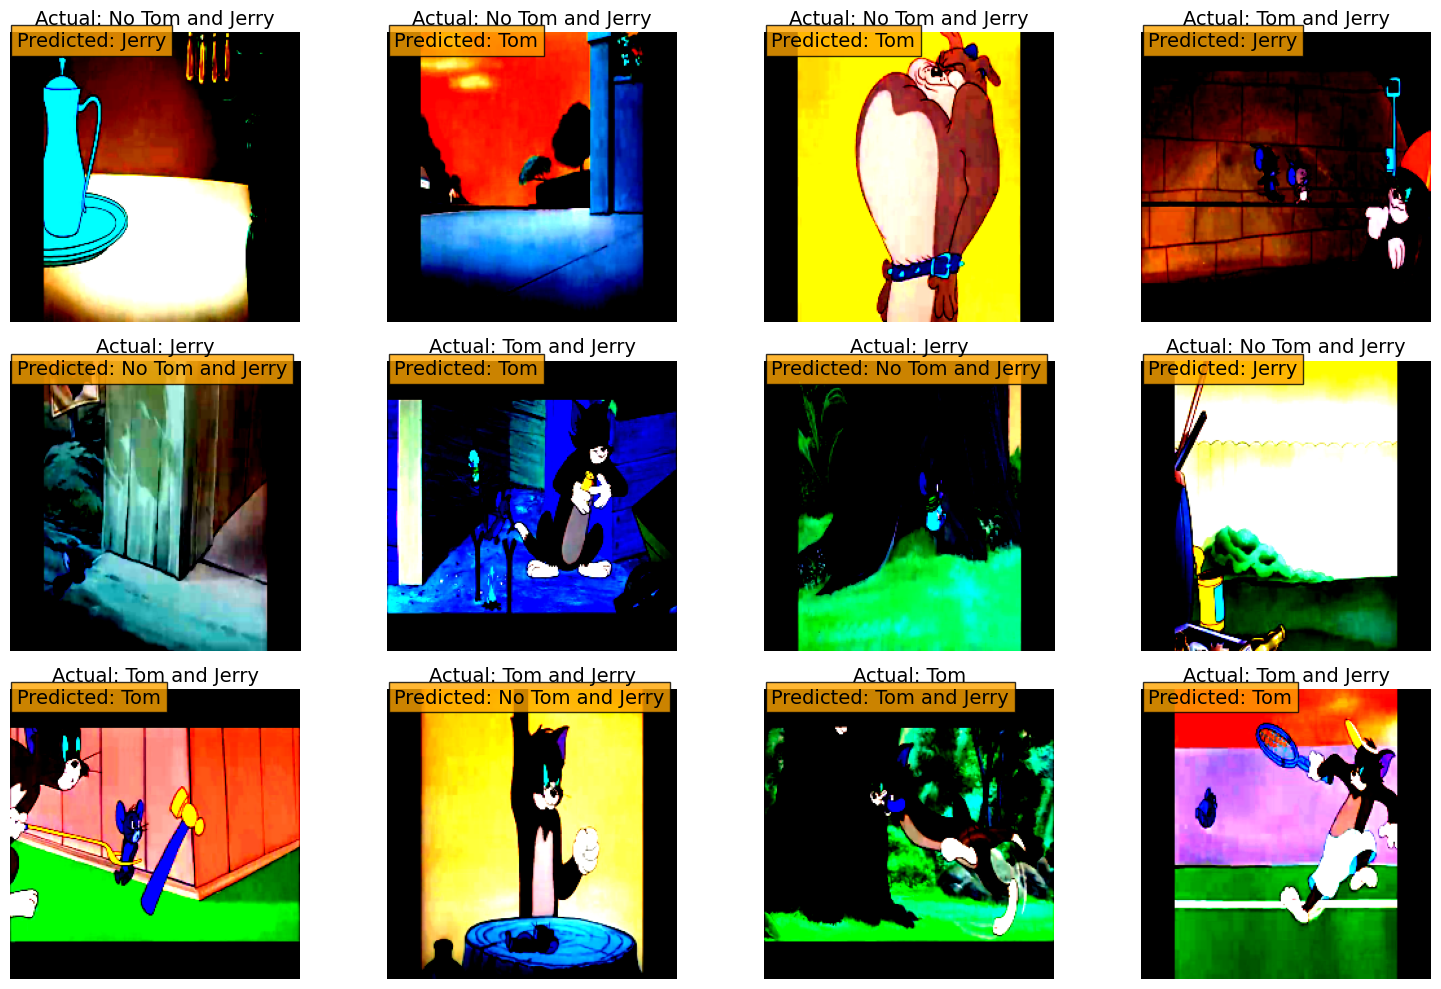

In [44]:
# Show the misclassification of predictive model (fixing labels)
# Define class mapping
class_map = {
    4: 'No Tom and Jerry',
    3: 'Tom and Jerry',
    2: 'Jerry',
    1: 'Tom'
}

# Identify misclassified indices
misclassified_indices = np.where(y_test_int + 1 != y_pred + 1)[0]  # Adding 1 to adjust for zero-indexed labels

# Extract misclassified images, true labels, and predicted labels
misclassified_images = X_test[misclassified_indices]
true_labels = y_test_int[misclassified_indices] + 1  # Adding 1 to adjust for zero-indexed labels
predicted_labels = y_pred[misclassified_indices] + 1  # Adding 1 to adjust for zero-indexed labels
# Check results
print("Sample of true_labels:")
print(true_labels[:sample_size])
print("Sample of predicted_labels:")
print(predicted_labels[:sample_size])

# Display misclassified images 
num_samples = min(12, len(misclassified_indices))  
rows = 3  
cols = num_samples // rows

plt.figure(figsize=(15, 10))

for i in range(num_samples):
    plt.subplot(rows, cols, i + 1)
    
    # Brighten the image by scaling pixel values
    brightened_image = misclassified_images[i] * 5
    
    # Ensure the image is in the range [0, 255] 
    brightened_image = np.clip(brightened_image, 0, 255) / 255.0
    
    plt.imshow(brightened_image)
    plt.title(f'Actual: {class_map.get(true_labels[i], "Unknown")}', fontsize=14)  # Use get method to handle unknown labels
    plt.axis('off')
    
    # Annotate predicted label
    predicted_label = class_map.get(predicted_labels[i], "Unknown")
    plt.text(5, 10, f'Predicted: {predicted_label}', bbox=dict(facecolor='orange', alpha=0.8), fontsize=14)
    
plt.tight_layout()
plt.show()


# Evaluation

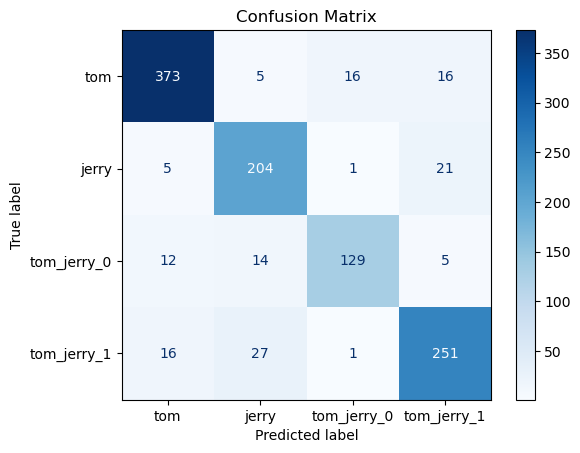

Class 'tom' - Precision: 0.92, Recall: 0.91, F1-score: 0.91
Class 'jerry' - Precision: 0.82, Recall: 0.88, F1-score: 0.85
Class 'tom_jerry_0' - Precision: 0.88, Recall: 0.81, F1-score: 0.84
Class 'tom_jerry_1' - Precision: 0.86, Recall: 0.85, F1-score: 0.85


In [22]:
# Confusion Matrix
# Compute confusion matrix
cm = confusion_matrix(y_test_int, y_pred)

# Compute precision, recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_int, y_pred, average=None)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_map.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print precision (TP/TP+FP), recall (TP/TP+FN), F1-score (avreage Precision & Recall) for each class
for label, prec, rec, f1 in zip(class_map.keys(), precision, recall, f1_score):
    print(f"Class '{label}' - Precision: {prec:.2f}, Recall: {rec:.2f}, F1-score: {f1:.2f}")

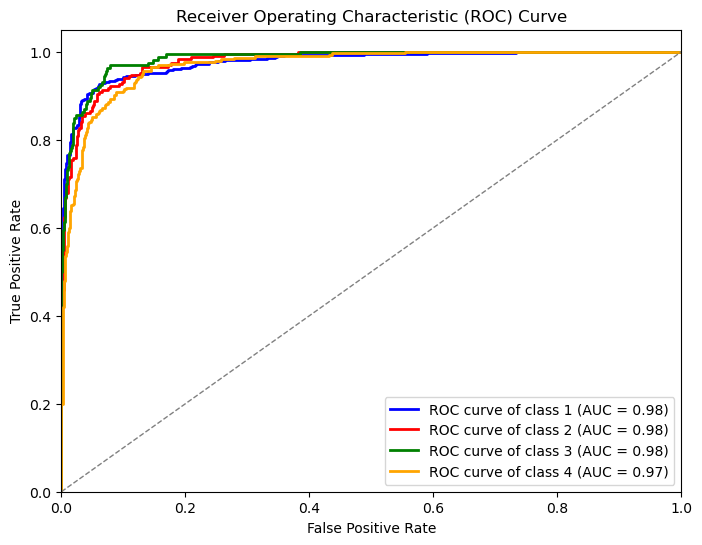

In [23]:
# ROC Curve
# number of lables
num_classes = len(np.unique(y_test_int))

# Compute ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple'] 

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
# pip install tf-explain

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


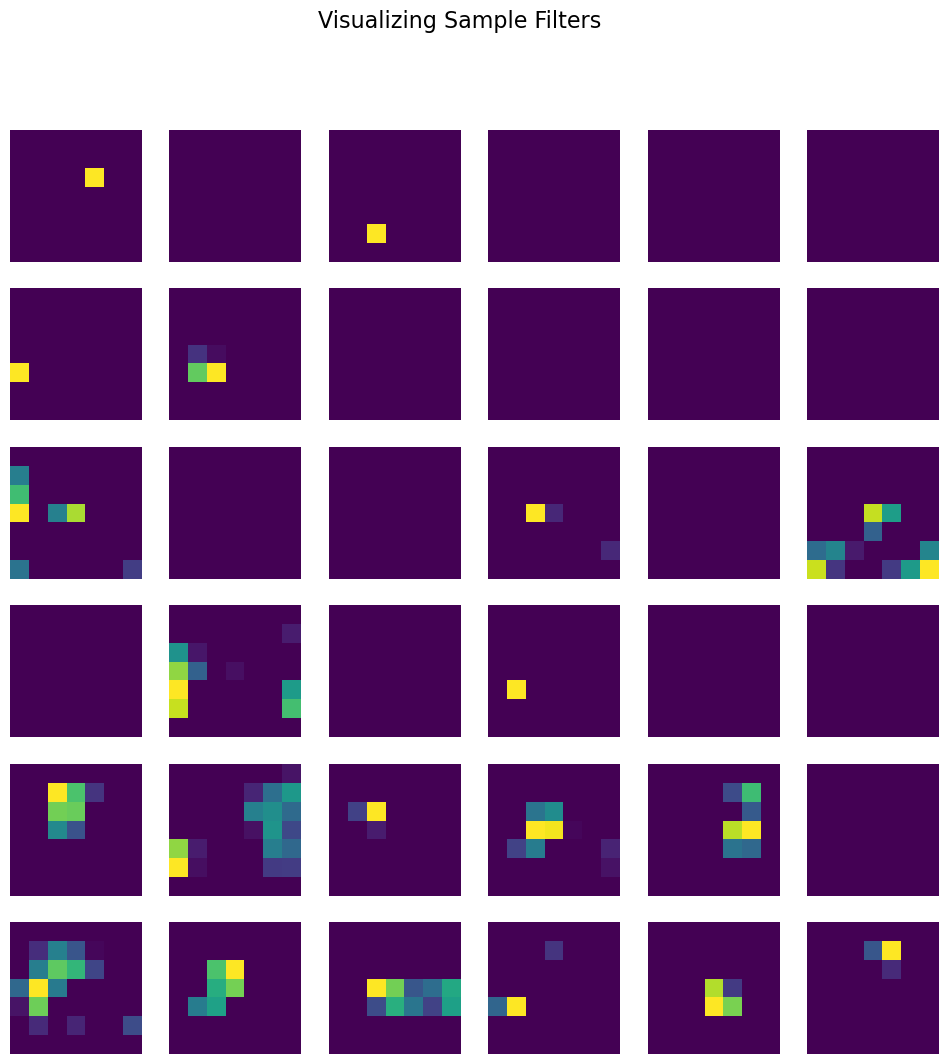

In [25]:

# Sample of Actived Filters 
# Load the VGG16 model 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Load an example image
img_path = r'C:\Users\admin\Desktop\Tom&Jerry\dataset\frame244.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Features Extraction 
features = base_model.predict(x)

# Visualize the first 36 filters in the first convolutional layer of VGG16
square = 6  # the number of filter that firstly scan 6*6
index = 0   # starting index for filter (position).
fig, ax = plt.subplots(square, square, figsize=(12, 12))

for i in range(square):
    for j in range(square):
        ax[i, j].imshow(features[0, :, :, index], cmap='viridis')
        ax[i, j].axis('off')
        index += 1

plt.suptitle('Visualizing Sample Filters', fontsize=16)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


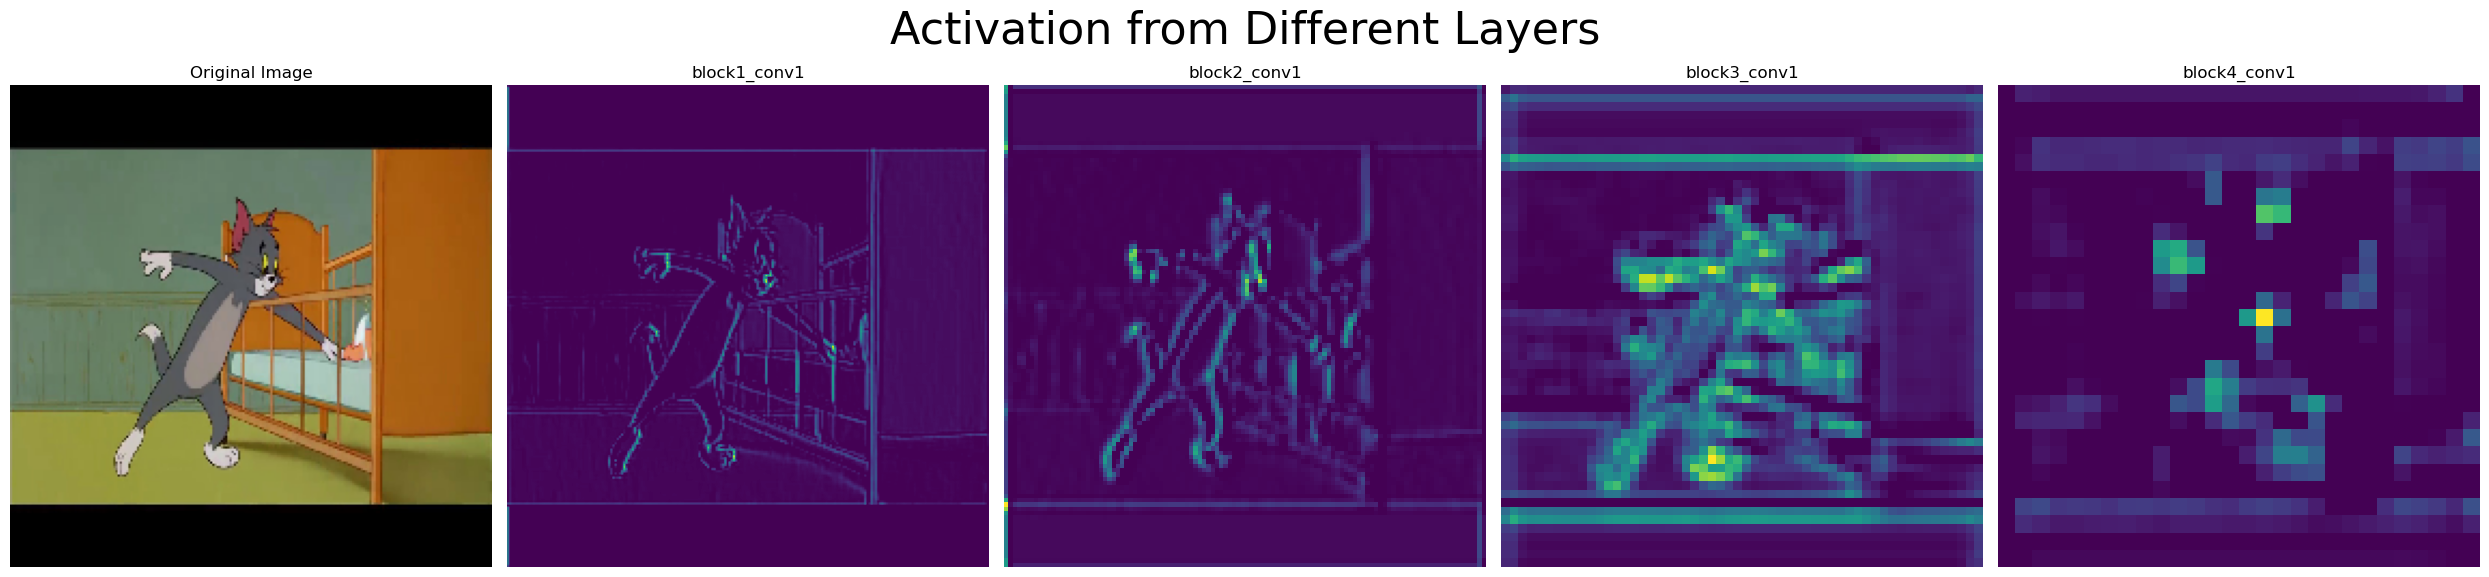

In [26]:
# Show activation normalize the feature map for visualization 
# Load the VGG16 model 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Load an example image
img_path = r'C:\Users\admin\Desktop\Tom&Jerry\dataset\frame244.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Function to visualize feature maps
def visualize_feature_maps(model, img_input):
    # Create a list of different layers
    layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']
    outputs = [model.get_layer(name).output for name in layer_names]
    # Create a activation model such as Relu that will output different layers 
    activation_model = Model(inputs=model.input, outputs=outputs)
    activations = activation_model.predict(img_input)
    
    # Display the original image
    plt.figure(figsize=(25, 6))
    plt.subplot(1, len(activations) + 1, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Display the feature maps
    for i, activation in enumerate(activations):  
        num_filters = activation.shape[-1]
        rows = num_filters // 8 + 1
        plt.subplot(1, len(activations) + 1, i + 2)
        plt.title(layer_names[i])
        for filter_index in range(num_filters):
            plt.imshow(activation[0, :, :, filter_index], cmap='viridis')
            plt.axis('off')
    
    plt.suptitle('Activation from Different Layers', fontsize=32)
    plt.tight_layout()
    plt.show()

# Visualize feature maps for the example image
visualize_feature_maps(base_model, x)



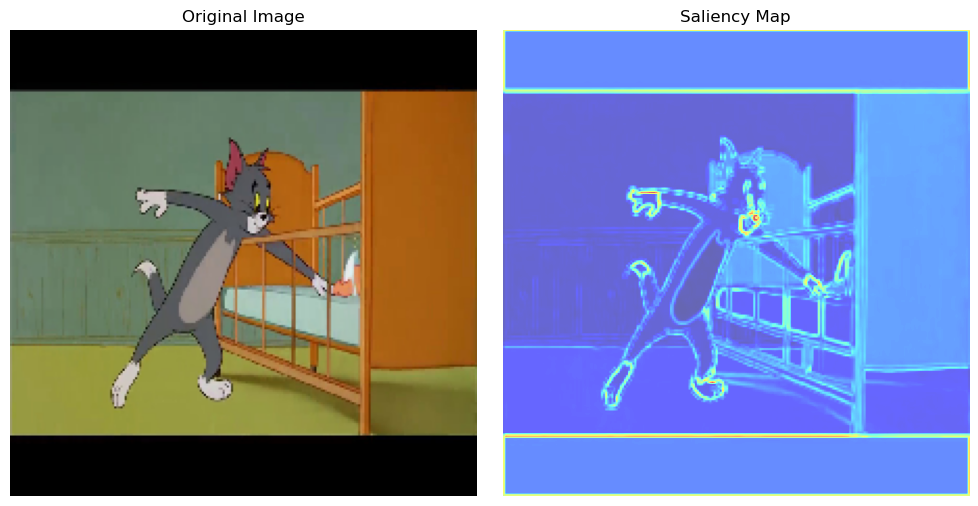

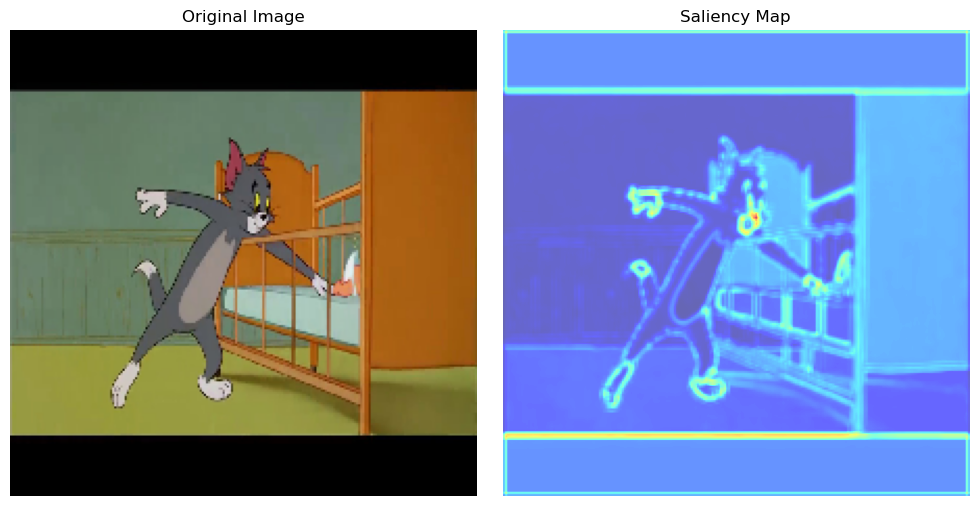

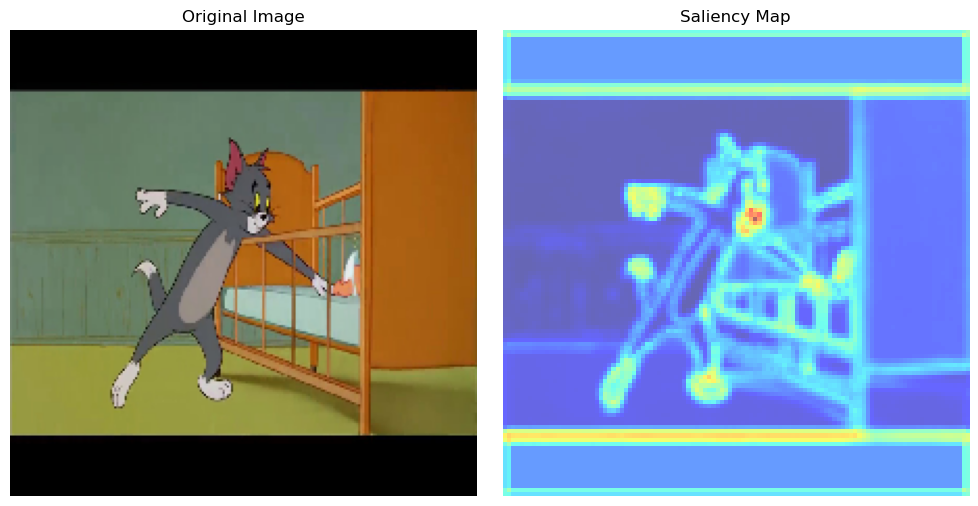

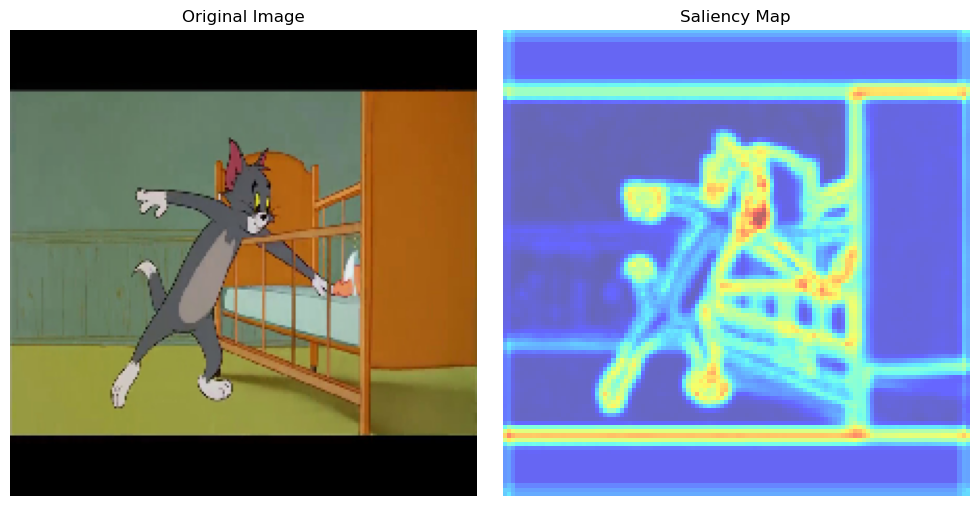

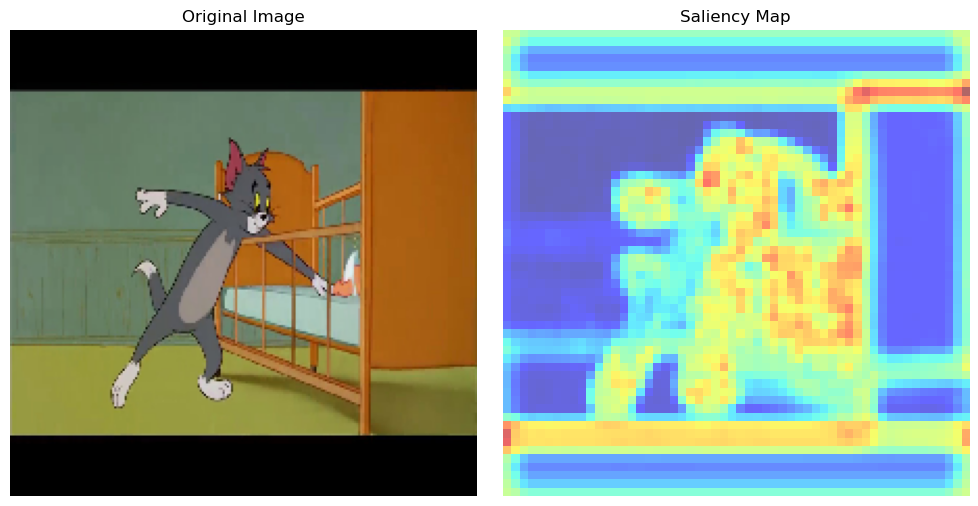

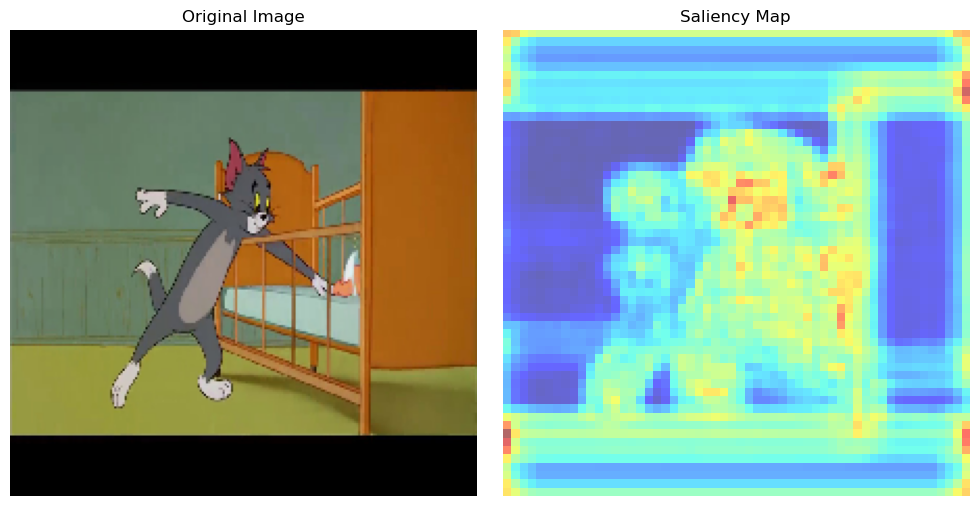

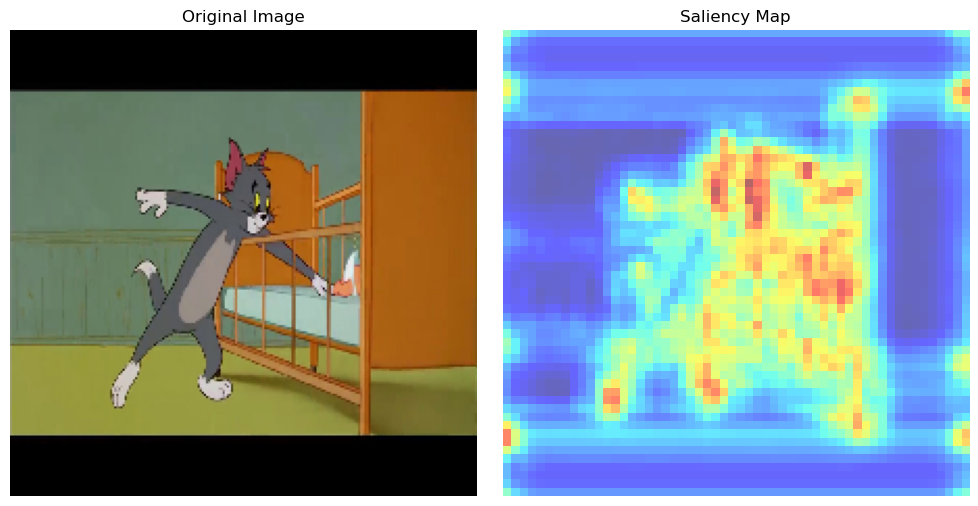

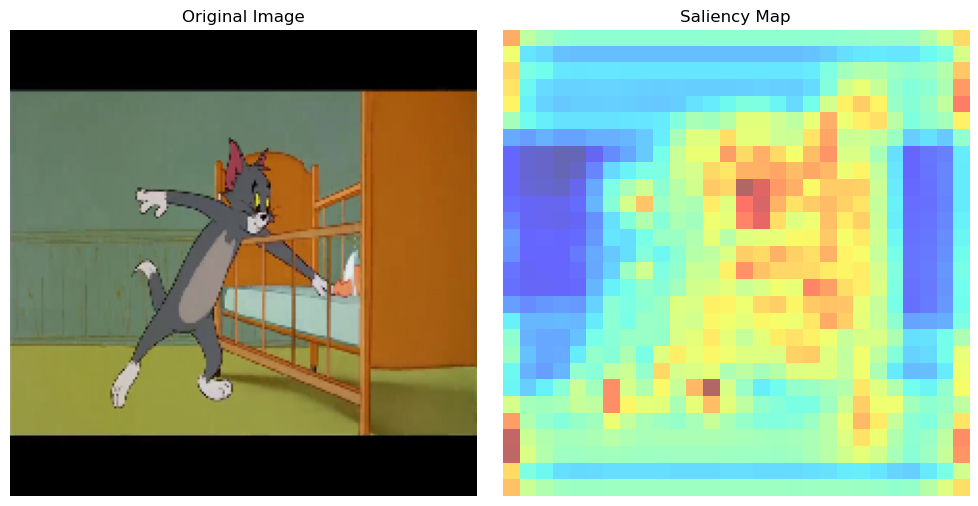

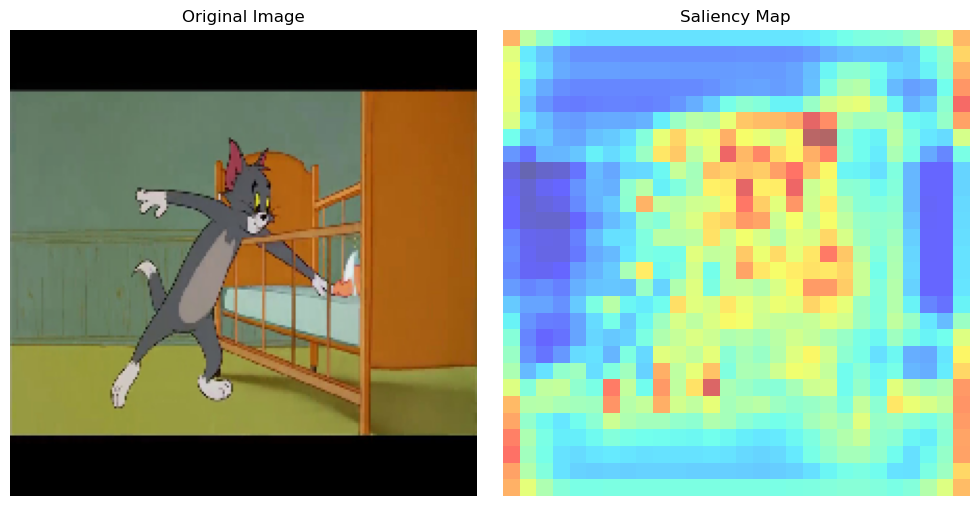

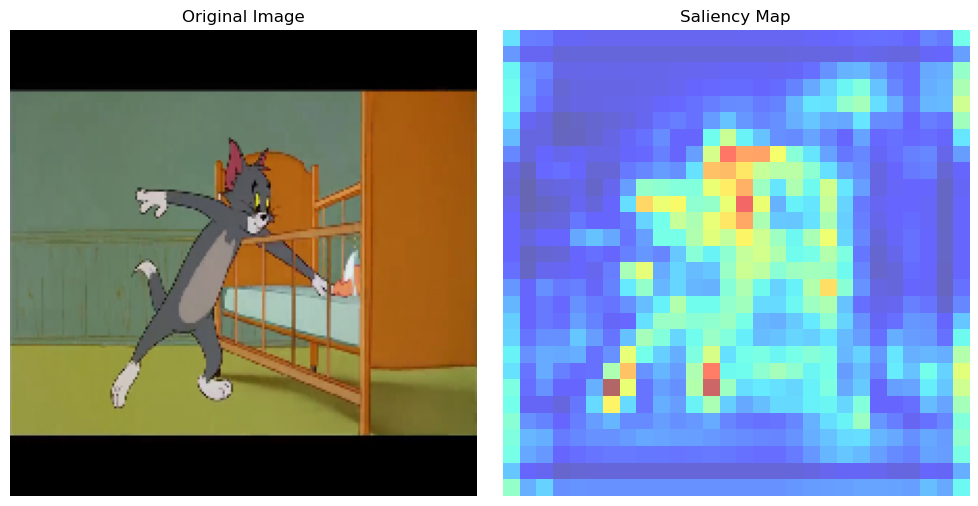

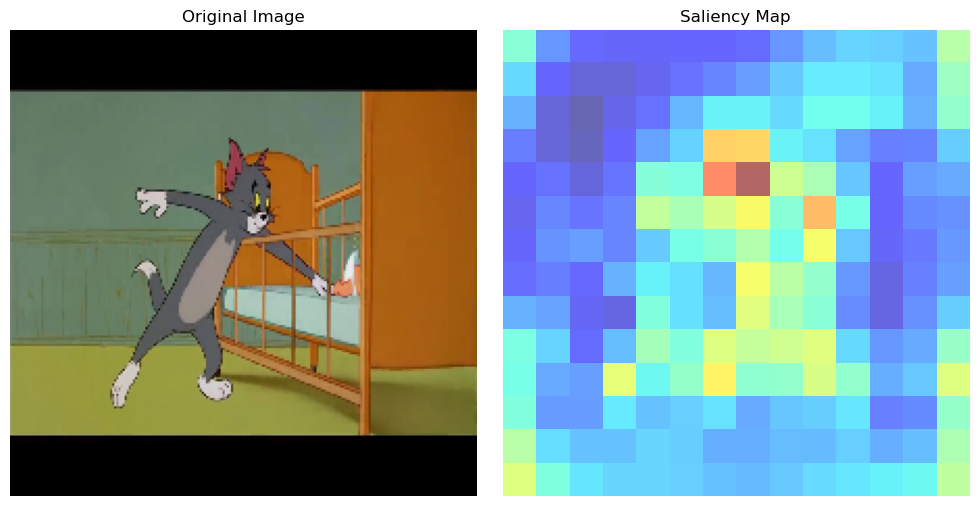

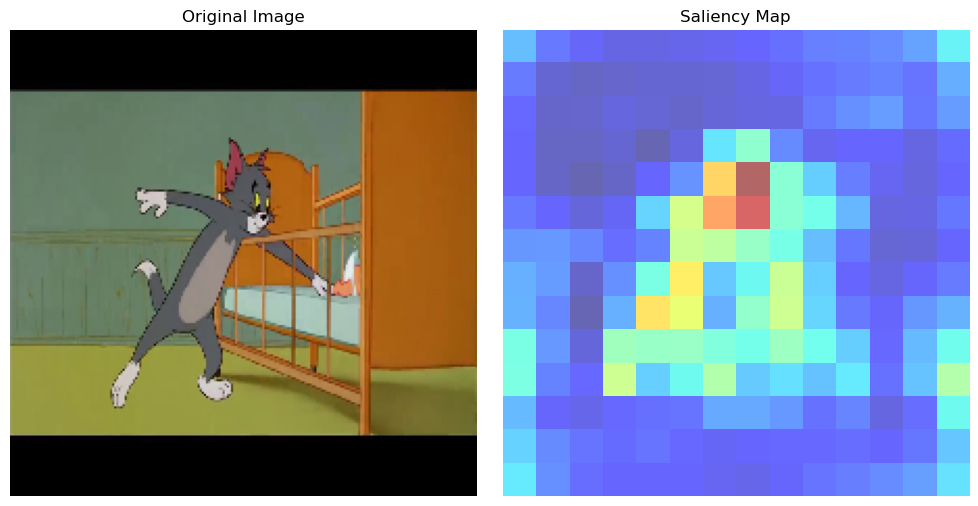

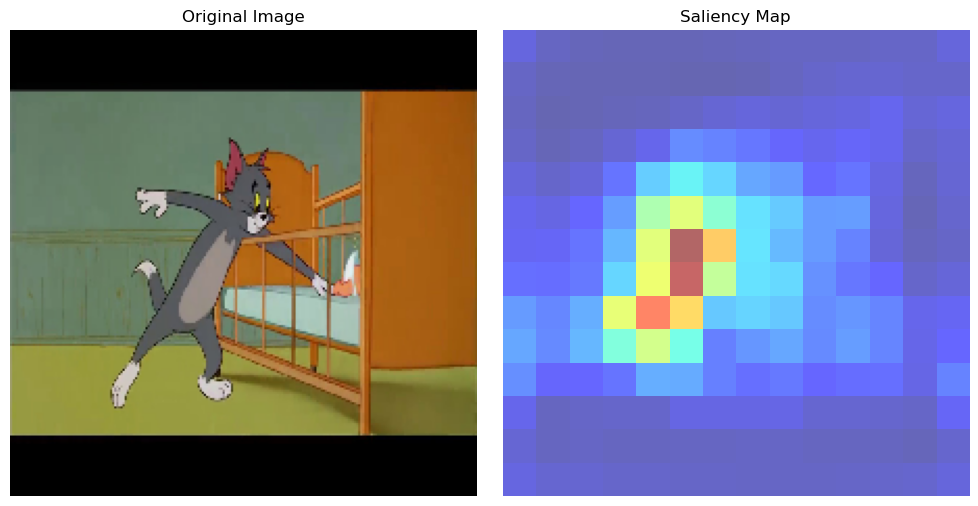

In [27]:
# Saliency Map (Tom): visualize the highlighted region that CNN make prediction

base_model = VGG16(weights='imagenet', include_top=True)
# Function to preprocess the image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

# Function to generate saliency map for a specific layer
def generate_saliency_map(model, img_input, class_index, layer_name):
    # Convert NumPy array to TensorFlow tensor
    img_input_tf = tf.convert_to_tensor(img_input)

    # Create a model that maps the input image to the gradients of the predicted class score with respect to the chosen layer's output
    grad_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)
    
    with tf.GradientTape() as tape:
        tape.watch(img_input_tf)
        preds = grad_model(img_input_tf)
        class_output = preds[:, class_index]

    # Compute gradients of class score with respect to the chosen layer's output
    grads = tape.gradient(class_output, preds)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = preds[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

# Function to overlay saliency map on the original image
def overlay_saliency_map(image, saliency_map):
    plt.figure(figsize=(10, 5)) #10 imgaes 5 rows
    #original
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    #saliency map
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='jet', alpha=0.6)
    plt.title('Saliency Map')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function to visualize saliency maps step-by-step
def visualize_saliency_maps_step_by_step(model, img_input, class_index):
    # Iterate through each convolutional layer and generate its saliency map
    for layer in model.layers:
        if 'conv' in layer.name:
            layer_name = layer.name
            saliency_map = generate_saliency_map(model, img_input, class_index, layer_name)
            
            # Overlay saliency map on the original image
            overlay_saliency_map(img, saliency_map)
            plt.pause(1)  # Pause to see each step
            plt.close()

# Example usage (Tom)
img_path = r'C:\Users\admin\Desktop\Tom&Jerry\dataset\frame244.jpg'
img, x = load_and_preprocess_image(img_path)

# Example class index (adjust based on your model)
class_index = 4

# Visualize saliency maps step-by-step
visualize_saliency_maps_step_by_step(base_model, x, class_index)


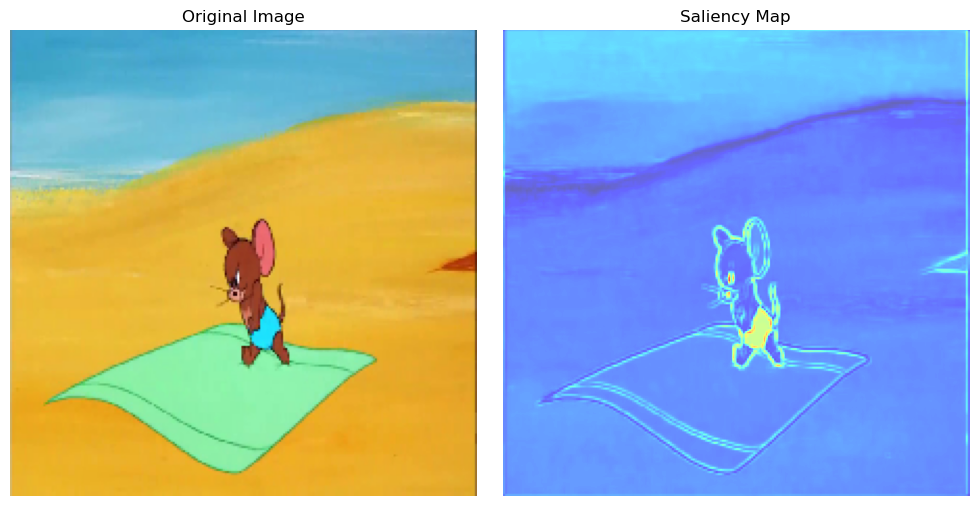

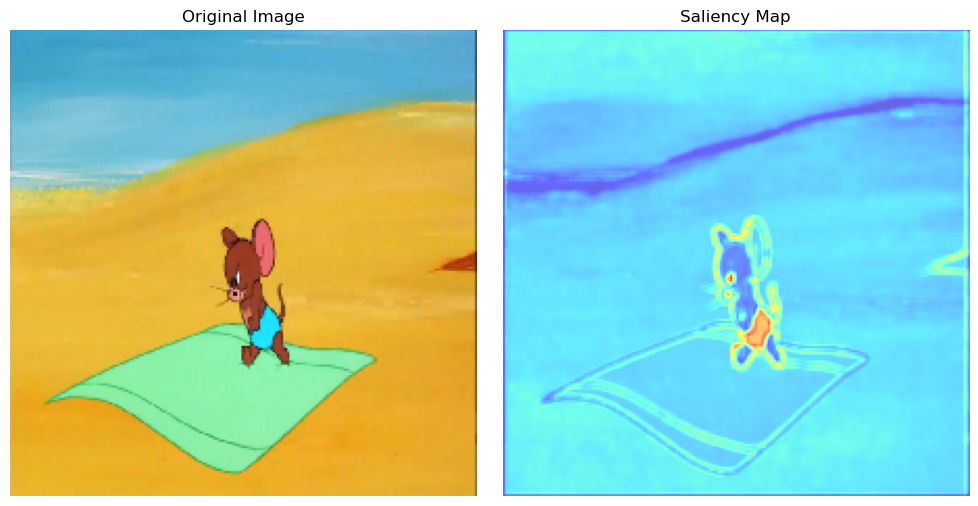

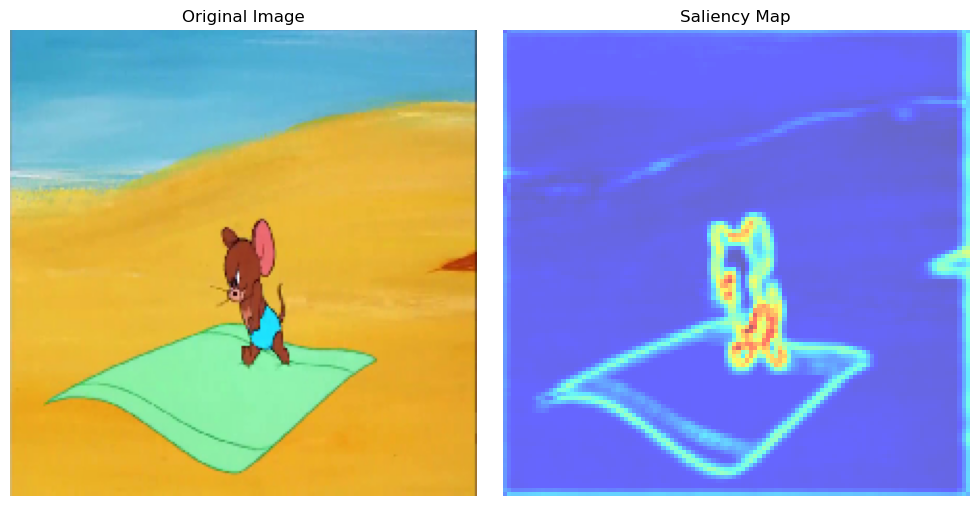

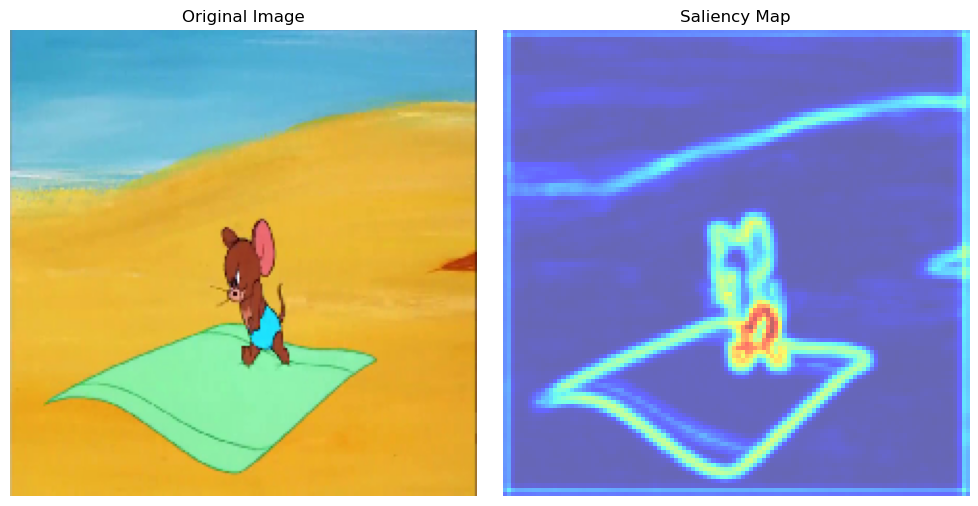

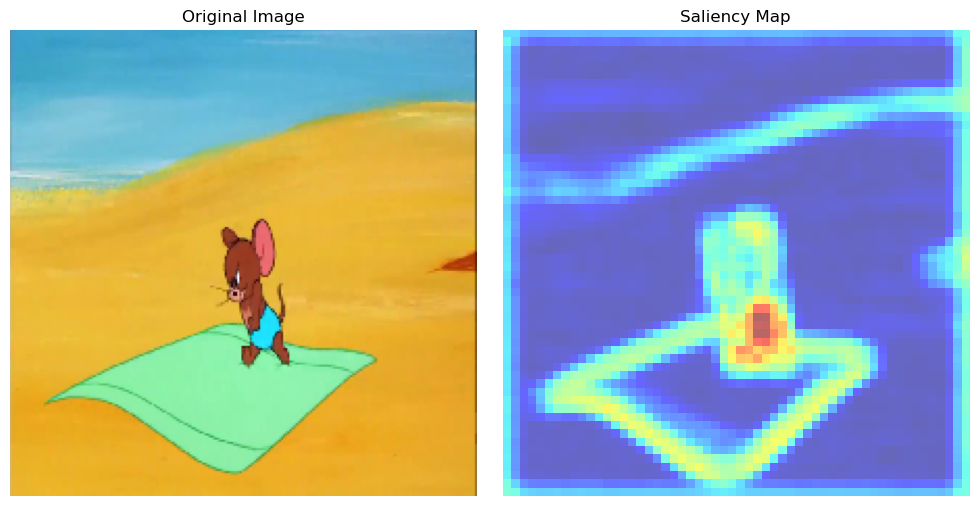

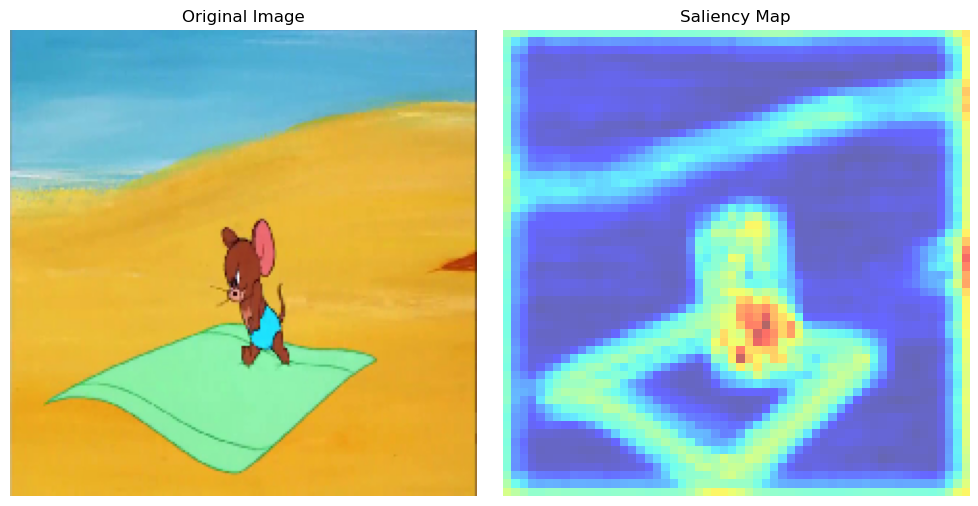

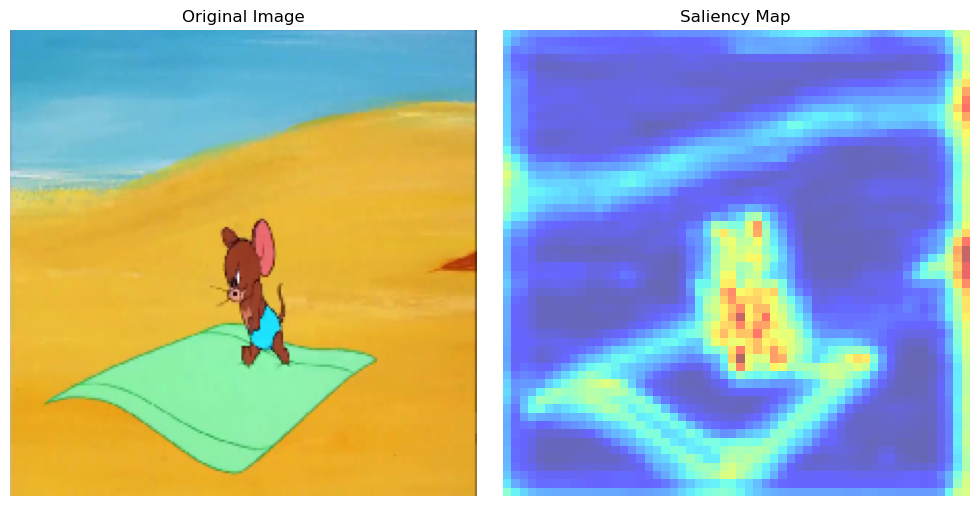

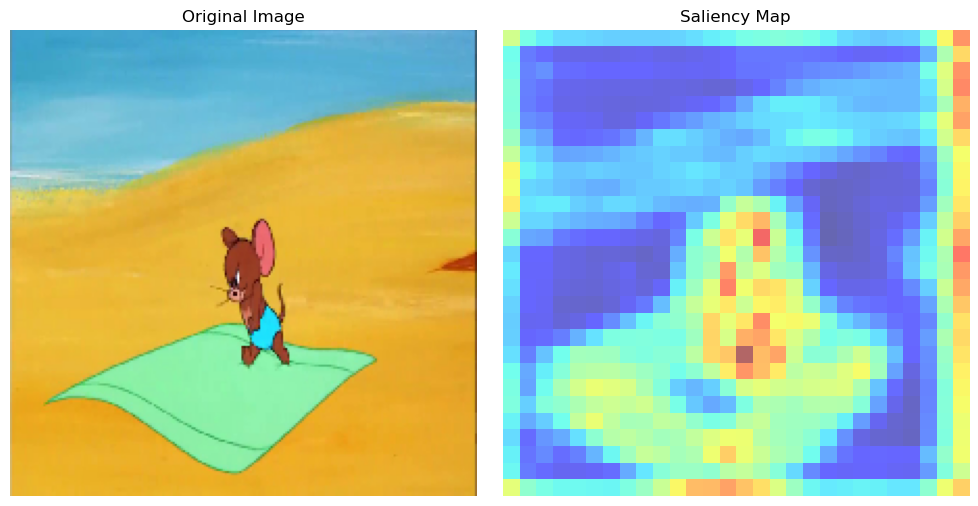

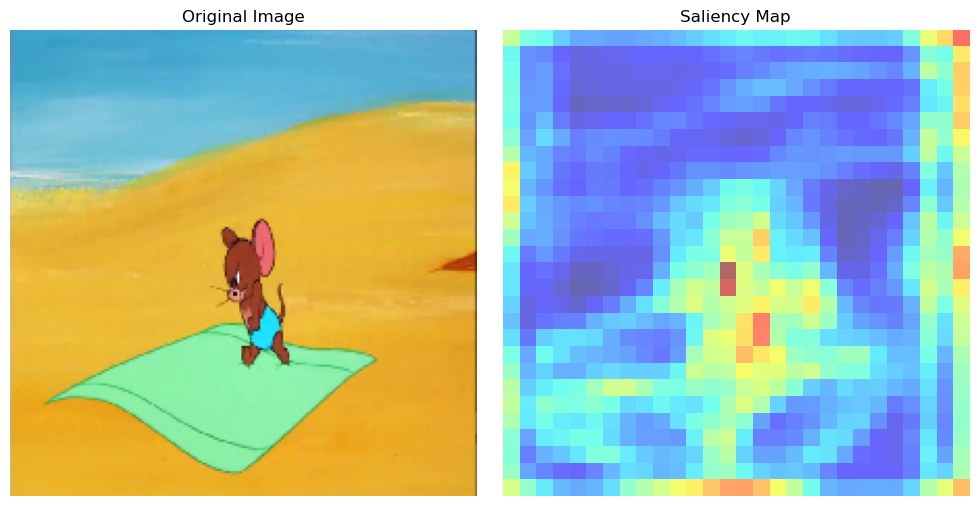

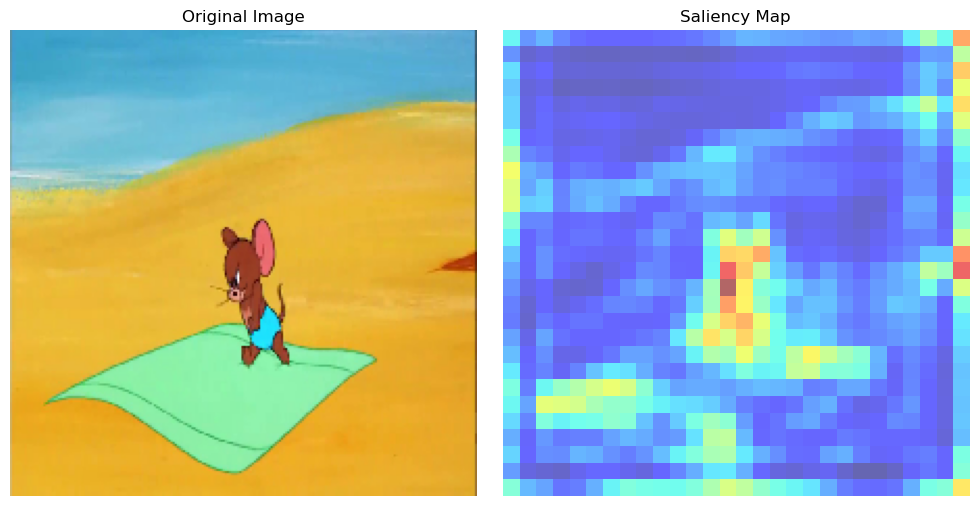

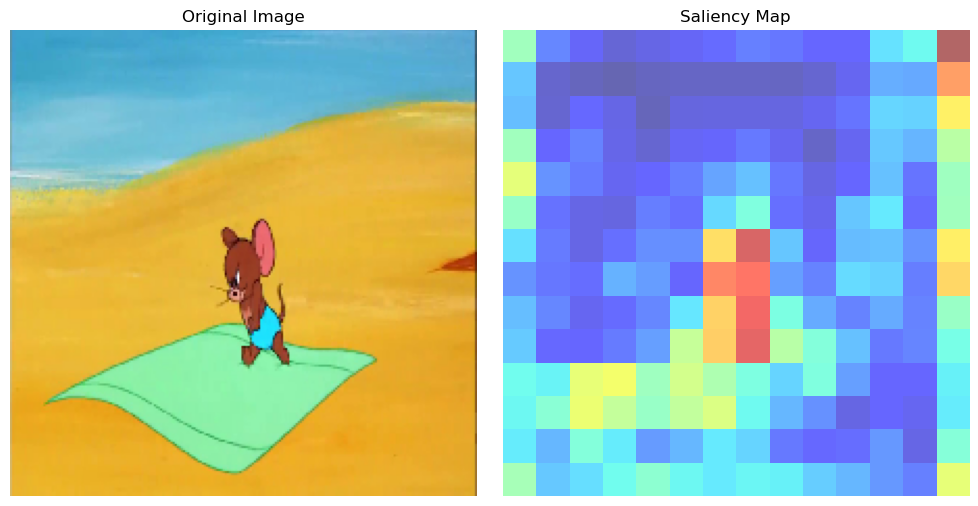

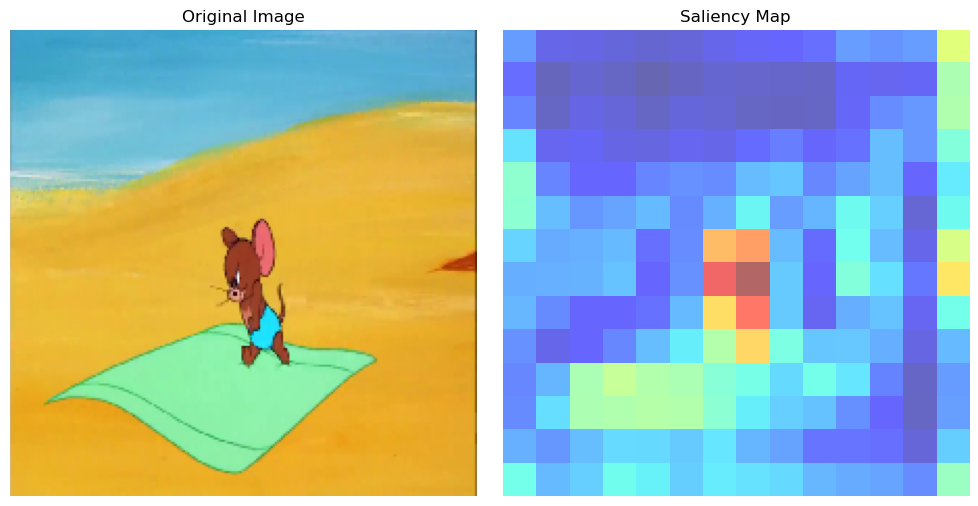

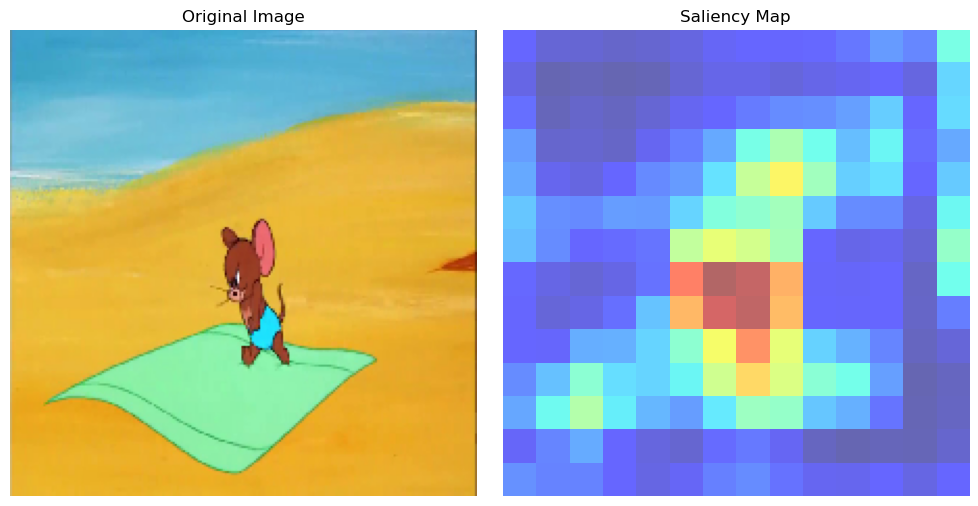

In [28]:
# Saliency Map (Jerry)
# Load the VGG16 model without the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=True)

# Function to preprocess the image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

# Function to generate saliency map for a specific layer
def generate_saliency_map(model, img_input, class_index, layer_name):
    # Convert NumPy array to TensorFlow tensor
    img_input_tf = tf.convert_to_tensor(img_input)

    # Create a model that maps the input image to the gradients of the predicted class score with respect to the chosen layer's output
    grad_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)
    
    with tf.GradientTape() as tape:
        tape.watch(img_input_tf)
        preds = grad_model(img_input_tf)
        class_output = preds[:, class_index]

    # Compute gradients of class score with respect to the chosen layer's output
    grads = tape.gradient(class_output, preds)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = preds[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

# Function to overlay saliency map on the original image
def overlay_saliency_map(image, saliency_map):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='jet', alpha=0.6)
    plt.title('Saliency Map')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to visualize saliency maps step-by-step
def visualize_saliency_maps_step_by_step(model, img_input, class_index):
    # Iterate through each convolutional layer and generate its saliency map
    for layer in model.layers:
        if 'conv' in layer.name:
            layer_name = layer.name
            saliency_map = generate_saliency_map(model, img_input, class_index, layer_name)
            
            # Overlay saliency map on the original image
            overlay_saliency_map(img, saliency_map)
            plt.pause(1)  # Pause to see each step
            plt.close()

# Example usage (Jerry)
img_path = r'C:\Users\admin\Desktop\Tom&Jerry\dataset\frame318.jpg'
img, x = load_and_preprocess_image(img_path)

# Example class index (adjust based on your model)
class_index = 4

# Visualize saliency maps step-by-step
visualize_saliency_maps_step_by_step(base_model, x, class_index)